In [8]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experiments.analysis_utils.data_processing import read_directory, clean_timesteps_ragequit_loop
from experiments.analysis_utils.metrics import count_ragequit_episodes, calculate_state_durations
from specs.dual_governance.state import State

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [18]:
path_to_runs = Path("../../results/simulations/rage_quit_loop/")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(
    path_to_runs.resolve(), pass_directory_name=True
)
timestep_data_df_full["run_id_str"] = timestep_data_df_full["run_id"].astype(str)

In [19]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on="run_id")
cleaned_timestep_data_df = clean_timesteps_ragequit_loop(timestep_data_df_full_with_params)

state_timesteps_df = cleaned_timestep_data_df.groupby(["run_id", "dg_state_name"]).size().unstack(fill_value=0)
for dg_state_name in ["Normal", "VetoSignalling", "VetoSignallingDeactivation", "VetoCooldown", "RageQuit"]:
    if dg_state_name not in state_timesteps_df.columns:
        state_timesteps_df[dg_state_name] = 0
state_timesteps_df *= 3 / 24

state_durations_df = calculate_state_durations(cleaned_timestep_data_df)
state_durations_df["duration_days"] = state_durations_df["duration"] * 3 / 24

# Since the simulations are finite in time, we need to calculate if the RageQuit loops are continuing beyond the simulation time
# We do this by checking two conditions:
# 1. The sum of the state durations is equal to the maximum number of timesteps.
#   This works because all the timesteps that do not belong to the RageQuit loop were truncated previously by clean_timesteps_ragequit_loop
# 2. There is at least one RageQuit state in the simulation

max_timesteps = timestep_data_df_full.groupby("run_id").timestep.max().max()

condition_1 = state_durations_df.groupby("run_id").duration.sum() == max_timesteps
condition_2 = state_durations_df.groupby("run_id")["state"].agg(lambda x: "RageQuit" in x.values)

# Multiply the conditions and negate the result
loop_continued = (condition_1 & condition_2)

# Create a DataFrame with "run_id" and "loop_continued"
loop_continued_df = loop_continued.reset_index(name='loop_continued')

In [20]:
ragequit_episodes_df = count_ragequit_episodes(cleaned_timestep_data_df)

starting_balances = (
    timestep_data_df_full_with_params[timestep_data_df_full_with_params["timestep"] == 1]
    .groupby("run_id")["actors_total_balance"]
    .sum()
)
state_timesteps_df_with_params = state_timesteps_df.merge(starting_balances, on="run_id")

state_timesteps_df_with_params = state_timesteps_df_with_params.merge(ragequit_episodes_df, on="run_id").merge(
    start_data_df_full[["run_id", "attacker_funds", "lido_exit_share", "second_seal_rage_quit_support"]], on="run_id"
)
state_timesteps_df_with_params["attacker_share"] = state_timesteps_df_with_params["attacker_funds"] / (
    state_timesteps_df_with_params["attacker_funds"] + 9000000
)
state_timesteps_df_with_params = state_timesteps_df_with_params.merge(loop_continued_df, on="run_id")

state_timesteps_df_with_params["loop_duration"] = state_timesteps_df_with_params["VetoSignalling"] + state_timesteps_df_with_params["VetoSignallingDeactivation"] + state_timesteps_df_with_params["RageQuit"]

state_timesteps_df_with_params["actors_total_balance"] = state_timesteps_df_with_params["actors_total_balance"].round().astype(int)

In [21]:
# print("Days in each state for each run, number of RageQuit events")
state_timesteps_df_with_params.set_index(['lido_exit_share', 'second_seal_rage_quit_support', 'attacker_share', 'actors_total_balance']).sort_index().loc[:,["ragequit_episodes", "loop_duration", "loop_continued", "Normal", "VetoSignalling", "VetoSignallingDeactivation", "RageQuit", "VetoCooldown", "run_id"]]

ragequit_episodes  \
lido_exit_share second_seal_rage_quit_support attacker_share actors_total_balance                      
0.3             0.05                          0.050000       4500000                               1   
                                                             9000000                               1   
                                                             18000000                              1   
                                              0.097500       4500000                               2   
                                                             9000000                               4   
...                                                                                              ...   
                0.15                          0.385875       9000000                              11   
                                                             18000000                             11   
                                              0.477994       4500000                              21   
                                                             9000000                              16   
                                                             18000000                             11   

                                                                                   loop_duration  \
lido_exit_share second_seal_rage_quit_support attacker_share actors_total_balance                  
0.3             0.05                          0.050000       4500000                      58.375   
                                                             9000000                      65.375   
                                                             18000000                     80.375   
                                              0.097500       4500000                     116.375   
                                                             9000000                     263.375   
...                                                                                          ...   
                0.15                          0.385875       9000000                     996.125   
                                                             18000000                   1439.375   
                                              0.477994       4500000                    1439.375   
                                                             9000000                    1439.375   
                                                             18000000                   1439.375   

                                                                                   loop_continued  \
lido_exit_share second_seal_rage_quit_support attacker_share actors_total_balance                   
0.3             0.05                          0.050000       4500000                        False   
                                                             9000000                        False   
                                                             18000000                       False   
                                              0.097500       4500000                        False   
                                                             9000000                        False   
...                                                                                           ...   
                0.15                          0.385875       9000000                        False   
                                                             18000000                        True   
                                              0.477994       4500000                         True   
                                                             9000000                         True   
                                                             18000000                        True   

                                                                                   Normal  \
lido_exit_share second

In [22]:
run_id = 3
print(
    f"Example run with RageQuit Loop, where attackers have {state_timesteps_df_with_params[state_timesteps_df_with_params.run_id == run_id].attacker_share.min():.3f} share of total pool"
)
state_durations_df[state_durations_df["run_id"] == run_id]

Example run with RageQuit Loop, where attackers have 0.098 share of total pool


,run_id,state,duration,duration_days
60,3,Normal,5,0.625
61,3,VetoSignalling,360,45.000
62,3,RageQuit,187,23.375
63,3,VetoSignalling,361,45.125
64,3,RageQuit,143,17.875
65,3,VetoSignalling,361,45.125
66,3,RageQuit,191,23.875
67,3,VetoSignalling,46,5.750
68,3,VetoSignallingDeactivation,10,1.250
69,3,VetoSignalling,305,38.125


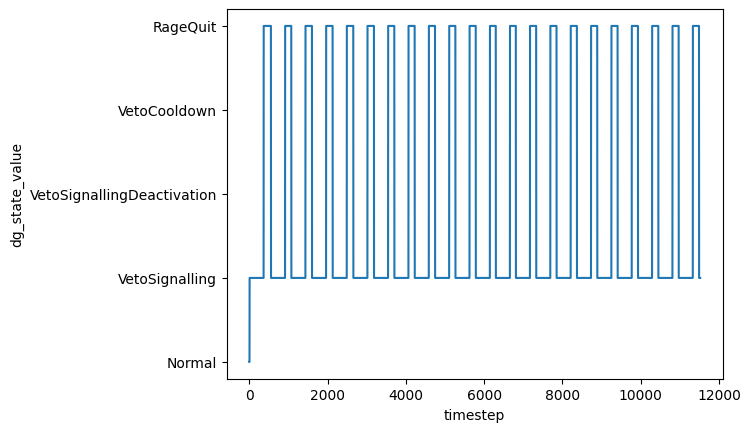

In [23]:
sns.lineplot(data=timestep_data_df_full[timestep_data_df_full["run_id"] == 5], x="timestep", y="dg_state_value")
plt.yticks([1, 2, 3, 4, 5])
from matplotlib.ticker import FuncFormatter

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{State(x).name}"))

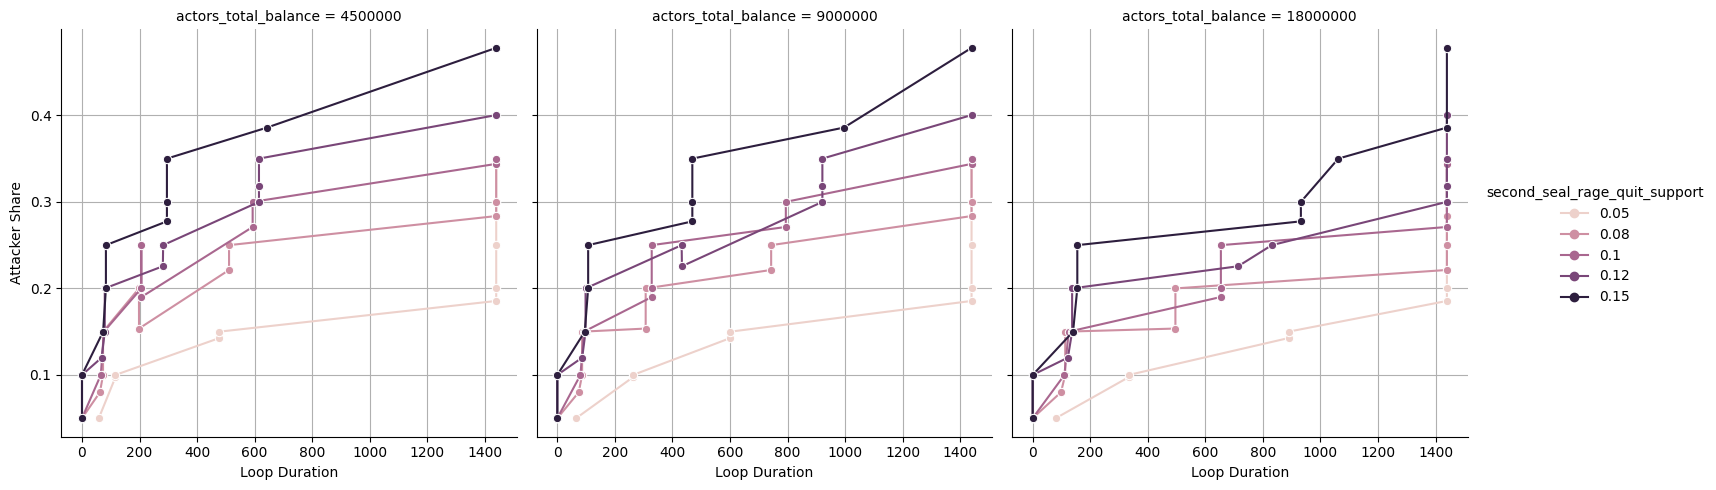

In [33]:
plot = sns.relplot(data=state_timesteps_df_with_params, x='loop_duration', y='attacker_share', col='actors_total_balance', hue='second_seal_rage_quit_support', kind='line', estimator=None, marker='o')
plot.set_axis_labels("Loop Duration", "Attacker Share")
for ax in plot.axes.flat:
    ax.grid(True)